# Project - Analyzing Chess Results with Python

## Data Preparation

I aim to analyze a database of classical chess games in python in order to assess how well ELO ratings can predict wins and losses, and to see if there are any more accurate ways to do so by including more variables.

In [406]:
import pandas as pd
import numpy as np 
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import seaborn as sb

Chess databases are typically stored in a specific file type (.pgn), the below function was written to extract the necessary information to a csv. This is quite a slow process given the number of games, so I've included the csvs in the zipped file so that it doesn't need to be run.

The best free source I could find was www.yottabase.com, where each player's games are available to download as a pgn. I downloaded these for the current top 20 by Classical ELO (note- I couldn't locate a file for #19 Vishy Anand so included #21 #TODO)

In [407]:
#merging the 20 individual csvs
dfs = []
for player in players:
    df = pd.read_csv(player +'.csv', index_col=None, header=0)
    dfs.append(df)
db = pd.concat(dfs, axis=0, ignore_index=True)

In [408]:
print(db.value_counts('Event'))

Event
tourn                 6539
swiss                 4548
blitz                 4258
rapid                 3146
tourn (blitz)         2748
team-swiss            1674
tourn (rapid)         1579
swiss (rapid)         1352
team-tourn            1301
k.o.                  1245
swiss (blitz)         1196
k.o. (blitz)           915
match (blitz)          847
team                   766
k.o. (rapid)           516
match                  400
schev                  376
match (rapid)          342
team-swiss (rapid)     249
simul                  137
team-schev              98
game                    77
schev (rapid)           65
team-k.o.               46
team-match              32
team-swiss (blitz)      21
team-tourn (blitz)      18
schev (blitz)           16
game (rapid)            15
simul (rapid)           10
team-tourn (rapid)       9
team-k.o. (rapid)        3
team-schev (blitz)       2
team (blitz)             1
game (corr)              1
dtype: int64


These are all the types of game in the database. Chess games can be split into four time formats: Blitz, Rapid, Classical and Correspondence. Since I am only interested in the classical games, I will remove all blitz, rapid and correspondence games, and also remove any games with null values in any of the columns. I am also removing team games as I'm not interested in these either.

In [409]:
#Removing any rows with null values
db = db.replace('*', np.nan)
db = db.dropna()

In [410]:
db = db[db["Event"].str.contains(r"blitz|rapid|k.o.|team|simul|corr")==False ]
print(db.value_counts('Event'))

Event
tourn    6254
swiss    4019
match     345
schev     287
game       59
dtype: int64


Now what I want to do is get each players ELO expected points for each game. ELO scores give a built-in value for a player's expected points per game, where the player gets one point for a win, 0.5 for a draw and none for a loss. According to https://www.cantorsparadise.com/the-mathematics-of-elo-ratings-b6bfc9ca1dba this is given by the formula:
E_a = 1/1(10^(R_b-R_w)/400)
We calculate this and add it to the dataframe. Since in every game there is one point won in total, Black's expected points will be equal to (1 - White's expected points), so we just add White's here. 
We also add the rating difference, R_w-R_b

In [411]:
db['Diff'] = db['WhiteELO'] - db['BlackELO']
db['Diff'] = pd.to_numeric(db['Diff'],errors='raise')
db['ExpWhitePoints'] = 1/(1+(10**((-db['Diff'])/400)))
db['ExpWhitePoints'] = pd.to_numeric(db['ExpWhitePoints'],errors='raise')

In [412]:
#Replacing the strings in the result column with numeric values for white's points.
db['WhitePoints'] = db['Result'].replace(r'0-\d', '0', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1-\d', '1', regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(r'1/2-\d.\d', '0.5', regex=True)
db['WhitePoints'] = pd.to_numeric(db['WhitePoints'],errors='raise')

## Exploratory Data Analysis

I would expect difference in ELO to be a strong indicator of whether white will win, draw or lose.

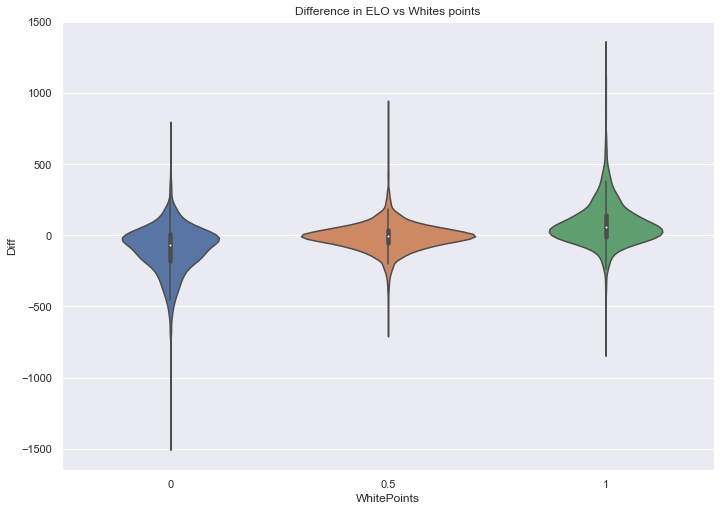

In [413]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.violinplot(x = 'WhitePoints', y = "Diff", order=[0, 0.5,1],data = db).set(title = 'Difference in ELO vs White''s points')
plt.show()

This violin plot shows the expected results on the whole, the difference is lowest for the losses and highest for the wins, meaning the higher the value of White's ELO - Black's ELO, the higher White's points.

To examine this data further, I'll segment the data into bins

<AxesSubplot:title={'center':'Whites average points vs difference in ELO'}, xlabel='bins', ylabel='WhitePoints'>

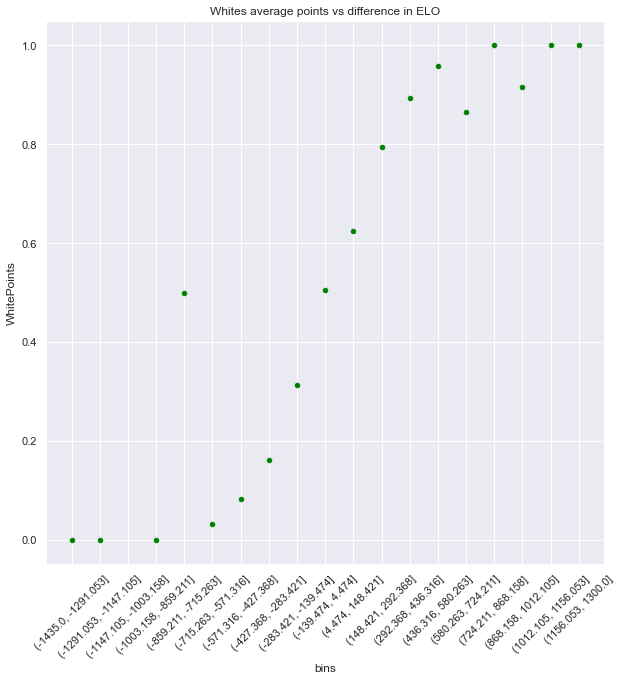

In [414]:
lb =database['Diff'].min().astype(int)
ub = database['Diff'].max().astype(int)
database_cut = database[['Diff','WhitePoints']]
database_cut = database_cut.sort_values(by = 'Diff',ascending=True)
bins =np.linspace(lb,ub,20)
database_cut['bins'] = pd.cut(database_cut['Diff'], bins = bins)#[-1500,-1400,-1300,-1200,-1100,-1000,-900,-800,-700,-600,-500,0,1500])
database_cut = database_cut[['bins','WhitePoints']]
database_cut_grouped = database_cut.groupby('bins').mean()
#print(database_cut_grouped)
database_cut_grouped['bins'] = database_cut_grouped.index.astype(str)
#print(database_cut_grouped.value_counts('bins'))
database_cut_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs difference in ELO')


So we can clearly see a positive relationship, although it doesn't look linear. Now instead of the difference in points I'll plot the same graph for ELO - implied expected white points.

<AxesSubplot:title={'center':'Whites average points vs ELO-implied expected points'}, xlabel='bins', ylabel='WhitePoints'>

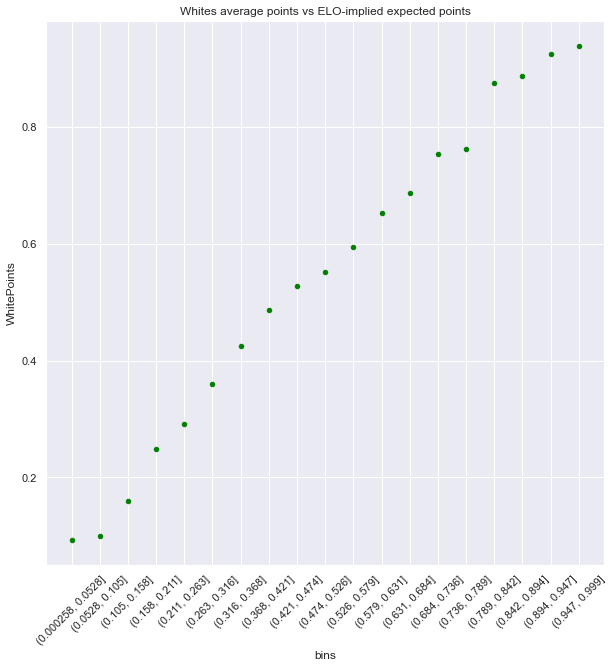

In [415]:
lb =database['ExpWhitePoints'].min().astype(float)
ub = database['ExpWhitePoints'].max().astype(float)
database_cut_ex = database[['ExpWhitePoints','WhitePoints']]
database_cut_ex = database_cut_ex.sort_values(by = 'ExpWhitePoints',ascending=True)
bins =np.linspace(lb,ub,20)
database_cut_ex['bins'] = pd.cut(database_cut_ex['ExpWhitePoints'], bins = bins)#[-1500,-1400,-1300,-1200,-1100,-1000,-900,-800,-700,-600,-500,0,1500])
database_cut = database_cut_ex[['bins','WhitePoints']]
database_cut_ex_grouped = database_cut_ex.groupby('bins').mean()
database_cut_ex_grouped['bins'] = database_cut_ex_grouped.index.astype(str)
database_cut_ex_grouped.plot.scatter(x='bins', y = 'WhitePoints', color = 'green', figsize = (10,10), rot = 45, title = 'White''s average points vs ELO-implied expected points')


This looks like a more clear linear relationship. Since I want to get the probability of a draw and a win, expected points alone doesn't provide enough information, but the mean squared error of the ELO-implied expected points might be an interesting benchmark to test a model's predicted points against.

In [416]:
print(mean_squared_error(db['WhitePoints'],db['ExpWhitePoints']))
print(mean_absolute_error(db['WhitePoints'],db['ExpWhitePoints']))

0.10134023032280967
0.24522727556488086


# Multinomial Regression

Running a multinomial regression, adding a variable 

In [417]:
#Setting a win to 2 and a draw to 1
db['WhitePoints'] = db['WhitePoints'].replace(1, 2, regex=True)
db['WhitePoints'] = db['WhitePoints'].replace(0.5, 1, regex=True)
db['ExpWhitePoints2'] = db['ExpWhitePoints']**2
db['Diff2'] = db['Diff']**2
db['WhiteELO2'] = db['WhiteELO']**2
train, test = train_test_split(db, test_size=0.2, random_state=166, shuffle=True)
print(db.value_counts('WhitePoints'))

WhitePoints
1.0    5525
2.0    3338
0.0    2101
dtype: int64


In [418]:
results1 = sm.MNLogit(train[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO', 'Diff2', 'WhiteELO2']], train['WhitePoints'])

In [419]:
results1.fit()

Optimization terminated successfully.
         Current function value: nan
         Iterations 2


In [420]:
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO', 'Diff2', 'WhiteELO2']]
Y_labels = db[['WhitePoints']]
X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.25, random_state =41, shuffle = True)

In [421]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [422]:
predicted = model.predict(X_train)
print("Accuracy for Train ", round(accuracy_score(y_train,predicted),3))

Accuracy for Train  0.533


In [423]:
predicted1 = model.predict(X_test)
print("Accuracy for Test: ", round(accuracy_score(y_test,predicted1),3))

Accuracy for Test:  0.534


In [424]:
print(log_loss(y_test, model.predict_proba(X_test)))
print(log_loss(y_train, model.predict_proba(X_train)))

print(np.array(np.unique(predicted1, return_counts=True)).T)
print(np.array(np.unique(y_test, return_counts=True)).T)
#print(model.predict_proba(X_train))

0.9856806987977469
0.9789520668444964
[[   0.    6.]
 [   1. 2383.]
 [   2.  352.]]
[[   0.  516.]
 [   1. 1392.]
 [   2.  833.]]


From this it looks like our model is predicting too many draws (value 1) compared to the training data. It's possible that is is just luck but it should become clearer when we perform K-fold validation.

# Cross-Validation and Hyper-Parameter Tuning

In [425]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#my parameter grid - note why do I limit to these parameters, are they the only ones possible>?
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)
clf = GridSearchCV(logreg, 
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)                      
                   
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=41),
             param_grid={'C': array([   0.001,    0.01 ,    0.1  ,    1.   ,   10.   ,  100.   ,
       1000.   ]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='neg_log_loss')

In [426]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : -0.8984842030815342


In [427]:
logreg = LogisticRegression(C = 1, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

Accuracy: 0.5924844947099599


In [428]:
print('model prediction: \n',np.array(np.unique(y_pred, return_counts=True)).T)
print('result: \n',np.array(np.unique(y_test, return_counts=True)).T)
pred = logreg.predict_proba(X_test)
log_loss(y_test, pred)


model prediction: 
 [[   0.  187.]
 [   1. 2065.]
 [   2.  489.]]
result: 
 [[   0.  516.]
 [   1. 1392.]
 [   2.  833.]]


0.9022986720440068

It still seems to be overpredicting the draw a bit

Adding in a new categorical variable for the event type

# Adding a new categorical variable for the event type

In [429]:
db= pd.get_dummies(db, columns = ['Event'])

In [430]:
X = db[['ExpWhitePoints','Diff','ExpWhitePoints2','WhiteELO','Event_game', 'Event_match', 'Event_schev', 'Event_swiss', 'Event_tourn', 'Diff2', 'WhiteELO2']]
Y_labels = db[['WhitePoints']]

X_train, X_test, y_train, y_test = train_test_split(X, Y_labels, test_size=0.25, random_state =41)


#my parameter grid - note why do I limit to these parameters, are they the only ones possible>?
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
    }

logreg = LogisticRegression(random_state=41)

clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='neg_log_loss',        
                   cv=10)
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Score :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Score : -0.8976456005943035


In [431]:
logreg = LogisticRegression(C = 1, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

pred = logreg.predict_proba(X_test)
print(log_loss(y_test, pred))

Accuracy: 0.5932141554177307
0.900340568742942


In [432]:
logreg.coef_

array([[ 0.        , -0.00608669,  0.55544507, -0.00055175,  0.01206594,
         0.25806261,  0.50457602,  0.16315056,  0.00835695,  0.00000295,
        -0.00000013],
       [ 0.        ,  0.00604654, -7.04537631,  0.00020637, -0.16688617,
         0.        , -0.48308574,  0.        ,  0.09921539, -0.00000622,
         0.00000032],
       [ 0.07582863,  0.00501532,  1.92714037, -0.00010247,  0.02350824,
        -0.24691165,  0.14764113, -0.12217263, -0.18032571, -0.00000013,
        -0.00000014]])

Examining the coefficients, it seems like a win for black is more likely in a match than a game, and a draw is slightly less likely! So not what I expected, but could also make sense with matches leading to more must-win games.

Accuracy is slightly lower but log-loss is improved upon adding Event type as a categorical variable. We will use this as our final model - since probability is more important to us than the actual classification

# Calculating expected points mean squared error

In [433]:
def exp_points(predictions):
    exps = []
    for prediction in predictions:
        exp = 0.5*prediction[1] + prediction[2]
        exps.append(exp)
    return exps
    
pred = logreg.predict_proba(X_test)
white_true_points = y_test/2
print(mean_squared_error(white_true_points,exp_points(pred)))
print(mean_absolute_error(white_true_points,exp_points(pred)))

0.09801267207992703
0.24109918535014233


Mean squared error and mean absolute error for our predicted points are lower than than for the implied ELO predicted points! So as well as also having a predictor of wins & draws, we seem to have a better predictor of points.